In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import *
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split
from sklearn import metrics

plt.style.use('seaborn')
sns.set(font_scale=2.5)
data = pd.read_csv('heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [2]:
#data preprocessing
cp = pd.get_dummies(data['cp'], prefix = "cp")
restecg = pd.get_dummies(data['restecg'], prefix = "restecg")
thal = pd.get_dummies(data['thal'], prefix = "thal")
slope = pd.get_dummies(data['slope'], prefix = "slope")

nd = [data, cp, restecg, thal, slope]
df = pd.concat(nd,axis=1)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,...,restecg_0,restecg_1,restecg_2,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,3,145,233,1,0,150,0,2.3,...,1,0,0,0,1,0,0,1,0,0
1,37,1,2,130,250,0,1,187,0,3.5,...,0,1,0,0,0,1,0,1,0,0
2,41,0,1,130,204,0,0,172,0,1.4,...,1,0,0,0,0,1,0,0,0,1
3,56,1,1,120,236,0,1,178,0,0.8,...,0,1,0,0,0,1,0,0,0,1
4,57,0,0,120,354,0,1,163,1,0.6,...,0,1,0,0,0,1,0,0,0,1


In [3]:
df = df.drop(columns = ['cp', 'restecg', 'thal','slope'])
df.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,...,restecg_0,restecg_1,restecg_2,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,63,1,145,233,1,150,0,2.3,0,1,...,1,0,0,0,1,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,1,...,0,1,0,0,0,1,0,1,0,0
2,41,0,130,204,0,172,0,1.4,0,1,...,1,0,0,0,0,1,0,0,0,1
3,56,1,120,236,0,178,0,0.8,0,1,...,0,1,0,0,0,1,0,0,0,1
4,57,0,120,354,0,163,1,0.6,0,1,...,0,1,0,0,0,1,0,0,0,1


In [4]:
#data split
x_df = df.drop(['target'], axis=1)
y_df = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size = 0.2, random_state = 2020)


In [5]:
#logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter = 1000)
model.fit(X_train,y_train)
y_pred_lr = model.predict(X_test)
print('Number of patient: {} \naccuracy: {:.2f}% '.format(y_test.shape[0], 100 * accuracy_score(y_test,y_pred_lr)))
print('Precision: {:.2f}% \nRecall: {:.2f}% \nF1-score: {:.2f}% '.format(100*precision_score(y_test,y_pred_lr),
                                                            100*recall_score(y_test,y_pred_lr),100*f1_score(y_test,y_pred_lr)))
confusion_matrix(y_test,y_pred_lr)

Number of patient: 61 
accuracy: 80.33% 
Precision: 82.86% 
Recall: 82.86% 
F1-score: 82.86% 


array([[20,  6],
       [ 6, 29]], dtype=int64)

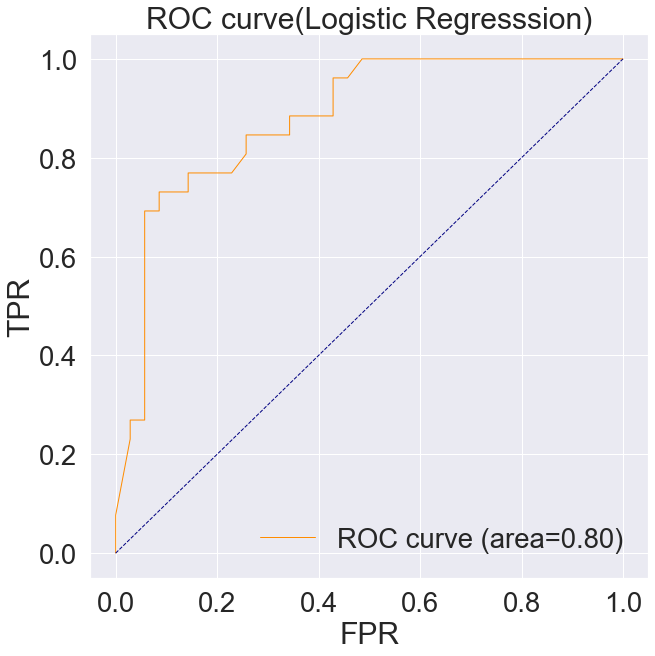

In [6]:
#roc curve of logistic regression
list = []
for i in np.linspace(0,1,100):
    pred = model.predict_proba(X_test)[:,1] > i
    cf_mtx = confusion_matrix(y_test, pred)
    acc = accuracy_score(y_test, pred)
    tpr = cf_mtx[0,0] / cf_mtx[0].sum()
    fpr = cf_mtx[1,0] / cf_mtx[1].sum()
    f1 = f1_score(y_test, pred)
    list.append([i, acc, f1, tpr, fpr])

cut_off = DataFrame(list)
cut_off.columns = ["CUTOFF", "ACC", "F1", "TPR", "FPR"]
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,10))
plt.plot(cut_off["FPR"],cut_off["TPR"], color="darkorange", lw=1, label="ROC curve (area=%.2f)" %roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
plt.title("ROC curve(Logistic Regresssion)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")

In [7]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=None, n_jobs=-1, random_state=2020)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
print('Number of patient: {} \naccuracy: {:.2f}% '.format(y_test.shape[0], 100 * accuracy_score(y_test,y_pred_rf)))
print('Precision: {:.2f}% \nRecall: {:.2f}% \nF1-score: {:.2f}% '.format(100*precision_score(y_test,y_pred_rf),
                                                            100*recall_score(y_test,y_pred_rf),100*f1_score(y_test,y_pred_rf)))
confusion_matrix(y_test,y_pred_rf)

Number of patient: 61 
accuracy: 77.05% 
Precision: 83.87% 
Recall: 74.29% 
F1-score: 78.79% 


array([[21,  5],
       [ 9, 26]], dtype=int64)

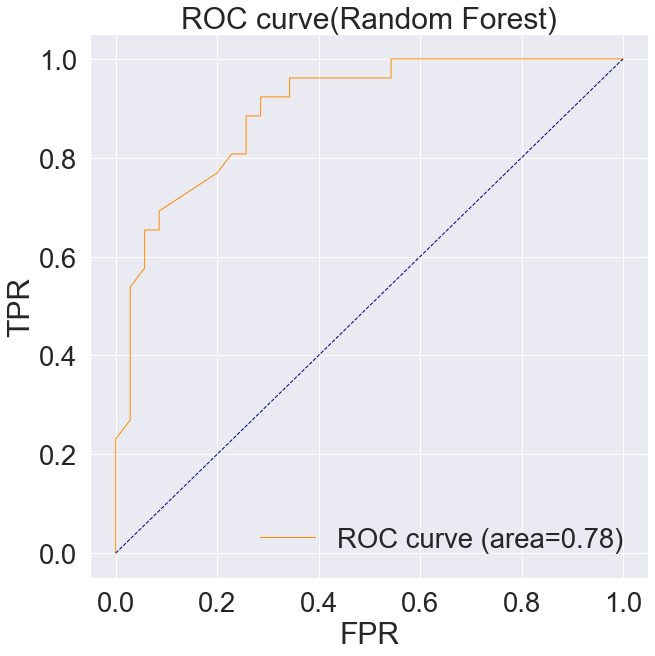

In [8]:
#roc curve of random forest
list = []
for i in np.linspace(0,1,100):
    pred = rnd_clf.predict_proba(X_test)[:,1] > i
    cf_mtx = confusion_matrix(y_test, pred)
    acc = accuracy_score(y_test, pred)
    tpr = cf_mtx[0,0] / cf_mtx[0].sum()
    fpr = cf_mtx[1,0] / cf_mtx[1].sum()
    f1 = f1_score(y_test, pred)
    list.append([i, acc, f1, tpr, fpr])

cut_off = DataFrame(list)
cut_off.columns = ["CUTOFF", "ACC", "F1", "TPR", "FPR"]
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,10))
plt.plot(cut_off["FPR"],cut_off["TPR"], color="darkorange", lw=1, label="ROC curve (area=%.2f)" %roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
plt.title("ROC curve(Random Forest)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc="lower right")

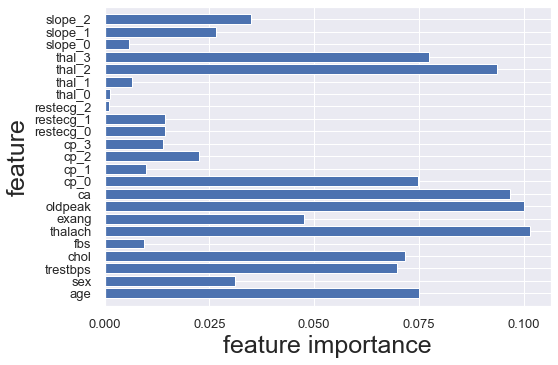

In [13]:
#feature importance
n_feature = X_train.shape[1]
index = np.arange(n_feature)
plt.barh(index, rnd_clf.feature_importances_, align='center')
plt.yticks(index, df.drop(['target'],axis=1).head(0))
plt.ylim(-1,n_feature)
plt.xlabel('feature importance', size=25)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('feature', size=25)
plt.show()

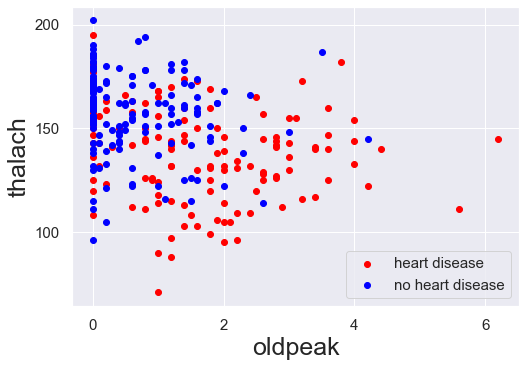

In [10]:
#most important two features and target graph
plt.scatter(x=df.oldpeak[df.target==0],y=df.thalach[df.target==0], c='red', label="heart disease")
plt.scatter(x=df.oldpeak[df.target==1],y=df.thalach[df.target==1], c='blue', label = "no heart disease")
plt.xlabel("oldpeak",fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("thalach",fontsize=25)
plt.legend(fontsize=15,frameon=True,loc = "lower right")
plt.show()